## set environment, import packages

In [ ]:
# if in Google Colab, uncomment and run this cell to connect to Google Drive data directory

# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Economic Recovery Tool Capstone')

Mounted at /content/drive


In [1]:
pip install geopandas cartoframes libpysal esda splot watermark -q

     |████████████████████████████████| 1.0 MB 17.6 MB/s 
     |████████████████████████████████| 245 kB 7.9 MB/s 
     |████████████████████████████████| 2.4 MB 31.6 MB/s 
     |████████████████████████████████| 116 kB 31.3 MB/s 
     |████████████████████████████████| 6.3 MB 33.1 MB/s 
     |████████████████████████████████| 16.7 MB 355 kB/s 
     |████████████████████████████████| 235 kB 35.6 MB/s 
     |████████████████████████████████| 209 kB 18.3 MB/s 
     |████████████████████████████████| 60 kB 3.1 MB/s 
     |████████████████████████████████| 179 kB 40.3 MB/s 
     |████████████████████████████████| 1.6 MB 41.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [3]:
import cartoframes
from cartoframes import to_carto, read_carto

In [ ]:
credentials = pd.read_csv('credentials.csv', names=[0,1])

In [ ]:
cartoframes.auth.set_default_credentials(
    username=credentials[1][0],
    api_key=credentials[1][1]
)

In [4]:
from libpysal.weights import Queen, KNN
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from splot._viz_utils import moran_hot_cold_spots

In [5]:
%reload_ext watermark
%watermark -iv -a 'Dan Levine' -u -d -v

Author: Dan Levine

Last updated: 2022-08-22

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

numpy      : 1.21.6
pandas     : 1.3.5
cartoframes: 1.2.4
geopandas  : 0.10.2



## read in and join data

In [ ]:
tracts = gpd.read_file('raw data/all_tracts_2019/all_tracts_2019.shp')

In [ ]:
tracts['GEOID'] = pd.to_numeric(tracts['GEOID'])

In [ ]:
broadband_data = pd.read_csv('processed data/coverage_usage_mlab_speed__area_weighted.csv', index_col=0)

In [ ]:
broadband_data

,area_weighted_WiredCount_2020,area_weighted_Wired25_3_2020,area_weighted_Wired100_3_2020,area_weighted_BROADBAND USAGE,area_weighted_mlab_AverageMbps,area_weighted_mlab_FastestAverageMbps,area_weighted_mlab_TestCount,GEOID
0,4.000000,2.000000,2.000000,1.000000,99.520000,234.930000,2189.380919,34005702808
1,3.000314,3.000314,3.000314,0.327040,33.191817,105.690772,64.260787,39153504200
2,6.000000,4.979500,3.989750,0.864404,119.719226,281.941103,584.342512,36071000502
3,5.000839,5.000839,5.000839,0.421460,91.383568,236.867713,882.561159,6013370000
4,9.997749,8.998523,7.999297,0.926883,142.144526,371.430960,7103.061717,48113019204
...,...,...,...,...,...,...,...,...
73863,7.683893,4.873377,4.873377,0.496744,64.672147,181.668107,1407.698674,48245011303
73864,4.999610,4.999610,4.999610,0.194160,85.217296,235.726194,967.905346,1073012302
73865,2.227884,2.227884,1.113931,0.000000,20.830893,55.188890,900.233275,72113072400
73866,5.003539,5.003539,5.003539,1.000000,110.467788,291.475775,3263.507805,6081608023


In [ ]:
broadband = tracts[['GEOID', 'geometry']].merge(broadband_data, on='GEOID', how='left')

## find outliers

In [ ]:
broadband_dropna = broadband.dropna(subset=['area_weighted_BROADBAND USAGE']).reset_index()

In [ ]:
knn_w = KNN.from_dataframe(
    broadband_dropna,
    k=5,
    geom_col='geometry',
    ids='GEOID')

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  warnings.warn(message)


In [ ]:
lisa = Moran_Local(
    y=broadband_dropna['area_weighted_BROADBAND USAGE'],
    w=knn_w,
    n_jobs=-1
)

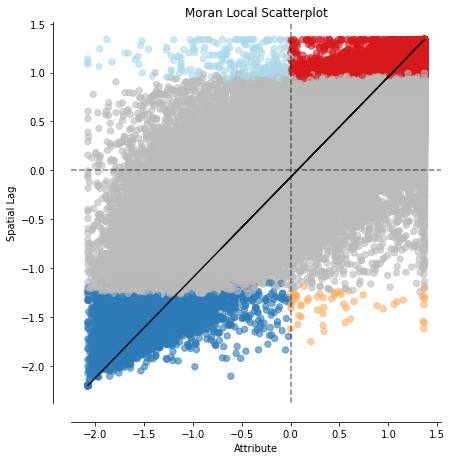

In [ ]:
fig, ax = moran_scatterplot(
    lisa,
    p=0.01
)

In [ ]:
lisa_quadrants = {
    0:np.nan,
    1:'HH',
    2:'LH',
    3:'LL',
    4:'HL'
}

In [ ]:
lisa_outlier = pd.Series(moran_hot_cold_spots(lisa,0.01)).map(lisa_quadrants)

In [ ]:
broadband_dropna['lisa_outlier'] = lisa_outlier

In [ ]:
broadband = broadband.merge(broadband_dropna[['GEOID','lisa_outlier']], on='GEOID', how='left')

In [ ]:
broadband

,GEOID,geometry,area_weighted_WiredCount_2020,area_weighted_Wired25_3_2020,area_weighted_Wired100_3_2020,area_weighted_BROADBAND USAGE,area_weighted_mlab_AverageMbps,area_weighted_mlab_FastestAverageMbps,area_weighted_mlab_TestCount,lisa_outlier
0,1055010700,"POLYGON ((-85.98699 34.04413, -85.98606 34.045...",7.998633,6.001346,5.999991,0.790294,88.107253,234.700064,4472.096953,NaN
1,1055001300,"POLYGON ((-86.00068 34.00537, -86.00023 34.006...",7.055336,6.944664,6.000000,0.299775,72.382451,186.308738,57.048870,NaN
2,1055000900,"POLYGON ((-86.07079 34.00011, -86.07076 34.000...",4.015455,3.012513,3.012513,0.434867,77.257196,225.299216,219.307307,NaN
3,1055001700,"POLYGON ((-85.96885 33.98825, -85.96884 33.988...",7.000000,7.000000,6.031913,0.274159,70.404340,180.538852,66.753127,NaN
4,1055010501,"POLYGON ((-86.07352 33.90549, -86.07337 33.906...",6.001636,5.999795,5.999427,0.669724,70.610174,151.972623,4844.645190,NaN
...,...,...,...,...,...,...,...,...,...,...
74096,72005400900,"POLYGON ((-67.15551 18.44182, -67.15539 18.442...",2.000000,2.000000,1.000000,0.000000,36.870000,161.040000,113.890803,LL
74097,72127008900,"POLYGON ((-66.05311 18.39677, -66.05293 18.396...",3.000000,2.152785,2.000000,0.000000,26.515406,52.670857,122.058130,LL
74098,72127009000,"POLYGON ((-66.04196 18.39833, -66.04193 18.398...",3.000000,3.000000,2.000000,0.000000,41.850000,88.830000,46.534617,LL
74099,72119130702,"POLYGON ((-65.86800 18.33762, -65.86785 18.338...",3.000000,3.000000,1.000000,0.000000,43.460000,121.800000,70.675774,LL


In [ ]:
broadband = broadband.rename(columns={'lisa_outlier':'broadband_usage_lisa_outlier'})

In [ ]:
broadband.to_csv('processed data/broadband usage with outliers.csv')

In [ ]:
to_carto(
    broadband,
    table_name='broadband percent usage and number of providers',
    if_exists='replace'
)

'broadband_percent_usage_and_number_of_providers'